In [40]:
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from astropy.constants import G
from galpy.potential import TwoPowerSphericalPotential, plotPotentials, evaluateDensities, plotRotcurve, PowerSphericalPotentialwCutoff
from galpy.util import conversion
import galpy.potential as gp
from galpy.orbit import Orbit

In [41]:
data = h5py.File("cutout_598597.hdf5", 'r')

In [42]:
data['PartType1']['SubfindDensity'][:10]
h = data['Header'].attrs['HubbleParam']
m = data['Header'].attrs['MassTable'][1]  / h * u.solMass * 10**10
a = data['Header'].attrs['Time']
l = data['Header'].attrs['BoxSize']


print(h)
print(m)
print(a)
print(l)

0.6774
538464.1418081385 solMass
0.9999999999999998
35000.0


In [43]:
coords = data['PartType1']['Coordinates'][:] / h
velocities = data['PartType1']['Velocities'][:]



In [44]:
def pot_x(x, coord): 
    x_n = np.array([x])
    x_i = np.repeat(x_n, len(coord), axis=0)
    return np.sum((- G*m /np.sqrt(np.sum((x_i - coord)**2, axis=1)) / u.kpc).to(u.m**2 / u.s**2))

In [45]:
l = data['Header'].attrs['BoxSize'] / h

com_coord = np.sum(coords,axis=0) / len(coords)
coords_centred = coords - com_coord
com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

r_min = np.min(com_dist)
r_max = np.max(com_dist)

x_ = np.linspace(0, l, 10)
y_ = np.linspace(0, l, 10)
z_ = np.linspace(0, l, 10)
potential_points = []
rs = []

for x in x_:
    for y in y_:
        for z in z_:
            potential_points.append(pot_x(np.array([x, y, z]), coords) * u.s**2 / u.m**2 / 1000)
            
            rs.append(np.sqrt((x - com_coord[0])**2 + (y - com_coord[1])**2 + (z - com_coord[2])**2))

In [46]:
axes_size = np.max(coords_centred, axis=0) - np.min(coords_centred, axis=0)
triax_par = (axes_size[1]**2 - axes_size[2]**2) / (axes_size[1]**2 - axes_size[0]**2)
print(triax_par)
print(axes_size[0]/ axes_size[1])

0.8127406609233666
0.6536388833936412


In [8]:
# Define grid
x_ = np.linspace(-2*r_max, 2*r_max, 50)
y_ = np.linspace(-2*r_max, 2*r_max, 50)
z_mid = com_coord[2]  # choose midplane

# Create empty array for potentials
potential_xy = np.zeros((len(y_), len(x_)))

# Compute potential on xy-plane at z=z_mid
for i, x in enumerate(x_):
    for j, y in enumerate(y_):
        r = np.array([x, y, z_mid])
        potential_xy[j, i] = pot_x(r, coords_centred) * u.s**2 / u.m**2  # assume returns scalar potential

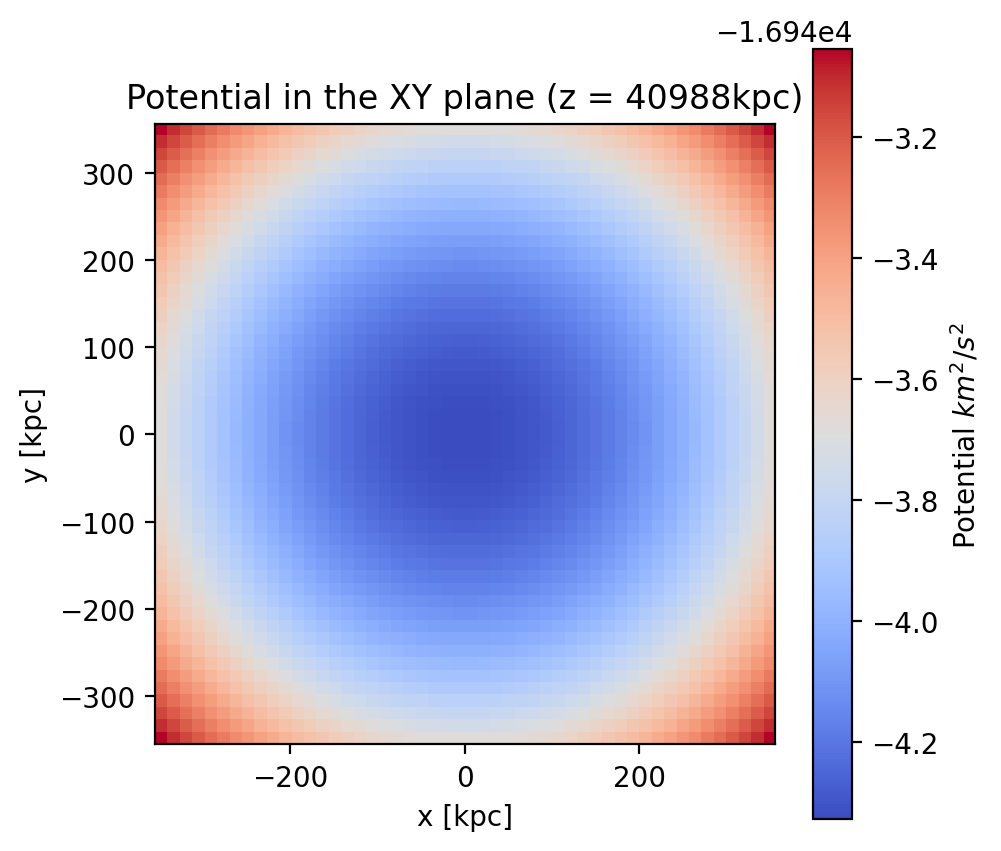

In [25]:
# Plot colormap
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(potential_xy / 1000, origin='lower', extent=[-2*r_max, 2*r_max, -2*r_max, 2*r_max], cmap='coolwarm')
plt.colorbar(label=r'Potential $km^2/s^2$')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Potential in the XY plane (z = {:.0f}kpc)'.format(z_mid))

plt.savefig('pot_xy')
plt.show()


2.6840447641126084


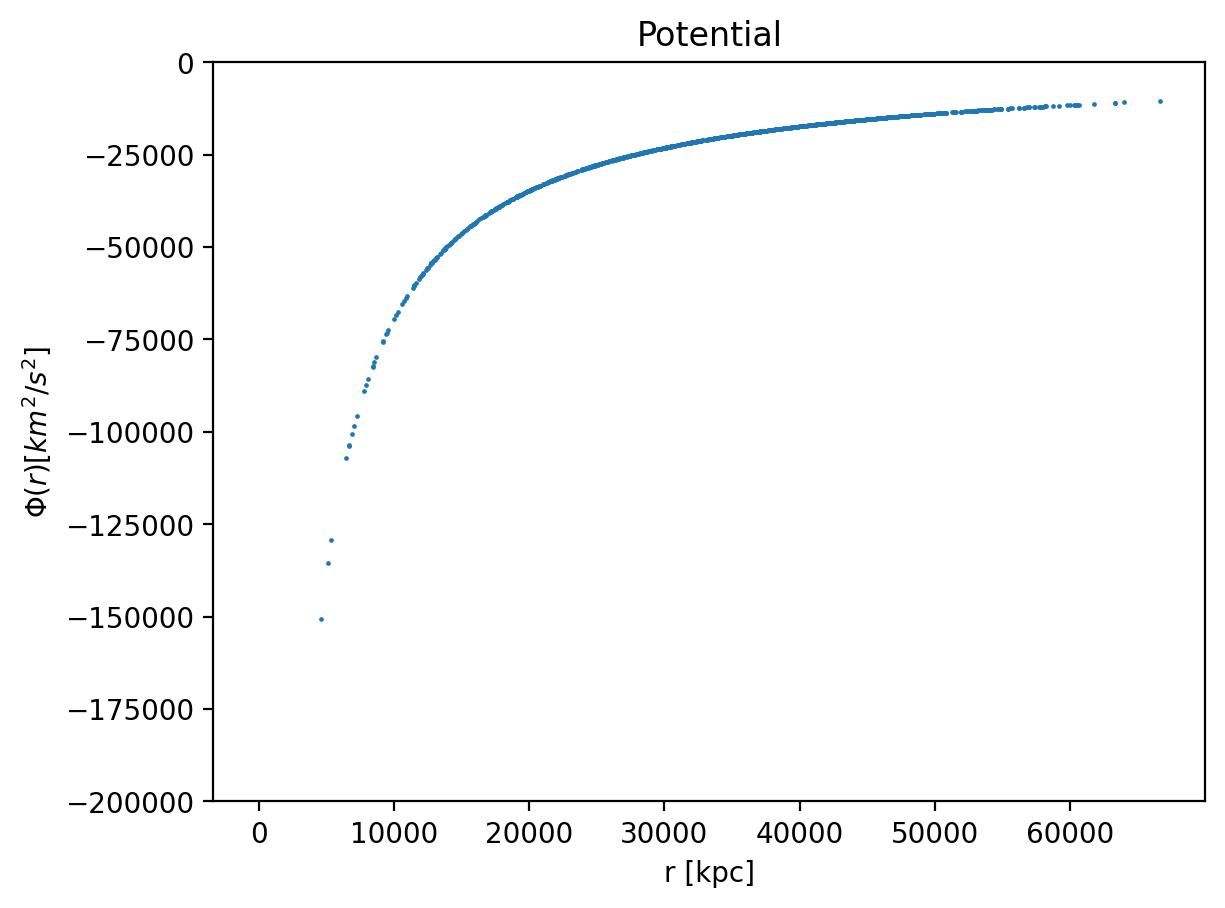

In [47]:

a_galpy = 1.70323
ampl_galpy = 909.306 * u.Msun / u.kpc**3
rc = 43.297 * u.kpc
lscale= 1109.310 * u.kpc

Phi = PowerSphericalPotentialwCutoff(amp=ampl_galpy, alpha=a_galpy, rc = rc, normalize=False, r1=lscale)
r = np.linspace(1, 60000, 1000)
phi_vals = [Phi(r_i, 0) * u.s**2 / u.km**2 for r_i in r]
fig, ax = plt.subplots(dpi=200)
ax.plot(r/ u.kpc, phi_vals)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Phi(r) [km^2/s^2]$")
plt.title("Potential")
ax.set_ylim(-2*10**5, 0)
ax.scatter(rs, potential_points, s = 0.5)
plt.savefig('pot')
plt.show()

83.22821084016284 km / s


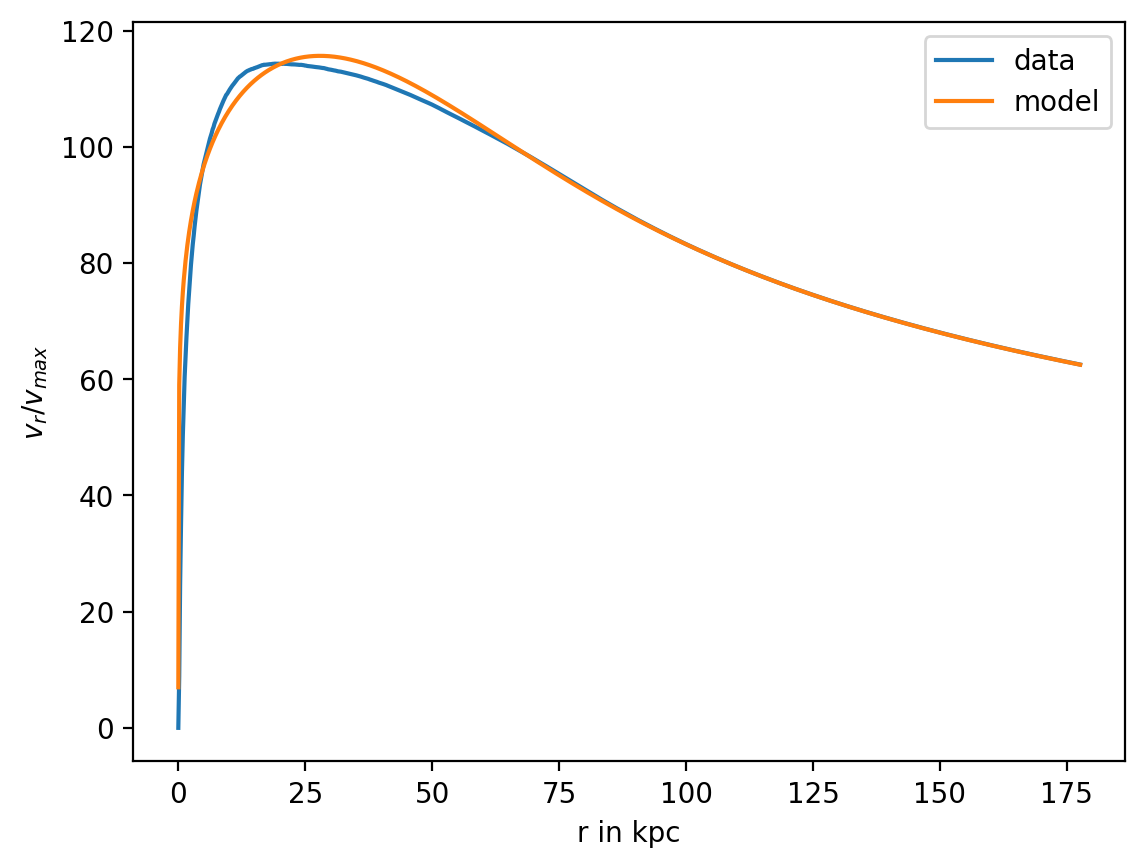

In [55]:
R = np.linspace(0.0000001, r_max, 1000) 
v_s = np.zeros(len(rs))
v_s_m = np.zeros(len(rs))
i = 0
for r in R:
    masses = (com_dist < r).sum()
    v_s[i] = (np.sqrt(G * m * masses /(r * u.kpc)).to(u.km/u.s))*u.s /u.km
    v_s_m[i] = gp.vcirc(Phi, r*u.kpc) *u.s /u.km
    i += 1


fig, ax = plt.subplots(dpi=200)
ax.plot(R, v_s, label='data')
ax.plot(R, v_s_m, label='model')
ax.set_ylabel(r'$v_r$ in km/s')
ax.set_xlabel('r in kpc')
plt.legend()
plt.savefig('rotc')
plt.show()

In [56]:
dens = evaluateDensities(Phi, r, 0, phi=None, t=0.0, forcepoisson=False)

In [57]:
def doublepowerlaw(r_kpc, ampl_solm, a_kpc, alpha, beta):
    constant = ampl_solm/(4*np.pi*(a_kpc**3))
    density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
    return density

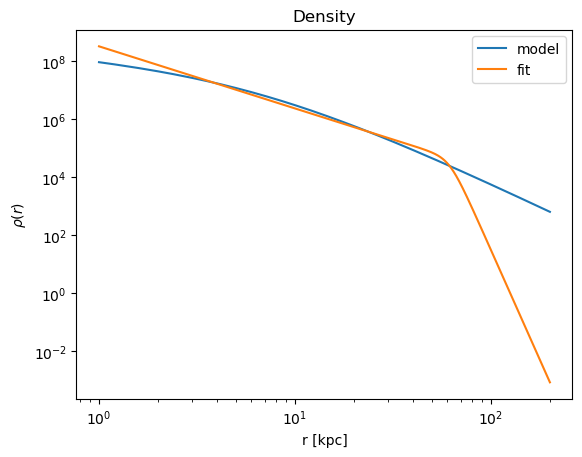

In [12]:
r = np.linspace(1, 200, 1000)
dens_vals = [doublepowerlaw(r_i, 1.408539e+11, 61.59979773,2.137631284420001, 15.157640182989251) for r_i in r]
dens = evaluateDensities(Phi, r, 0, phi=None, t=0.0, forcepoisson=False)
fig,ax = plt.subplots()
ax.plot(r/ u.kpc, dens, label='model')
ax.plot(r/ u.kpc, dens_vals, label='fit')
plt.xlabel("r [kpc]")
plt.ylabel(r"$\rho(r)$")
plt.title("Density")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

C:\Users\brent\anaconda3\envs\TANA2025\Lib\site-packages\galpy\potential\Potential.py:412: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(



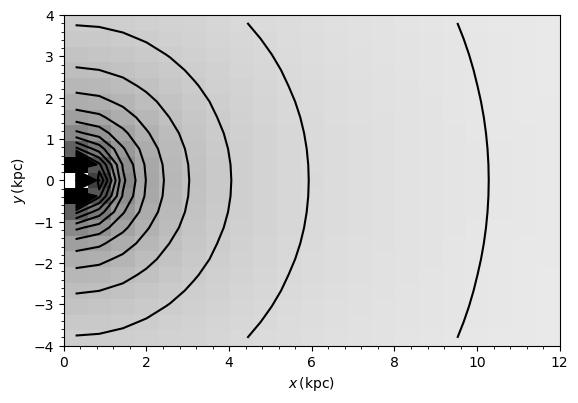

In [58]:
Phi.plotSurfaceDensity()

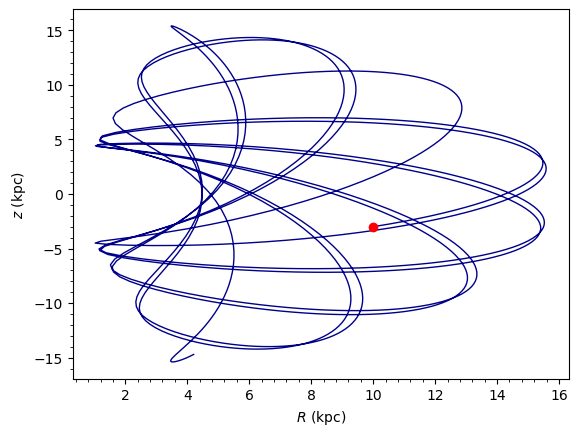

In [64]:
o2 = Orbit([10*u.kpc, 100*u.km/u.s, 17*u.km/u.s, -3*u.kpc, 45*u.km/u.s, 6*u.rad])
ts = np.linspace(0.,5000,1000)*u.Myr
o2.integrate(ts,Phi)

o2.plot(lw=1, c='darkblue');
plt.plot([o2.R().to_value()],[o2.z().to_value()],'ro');

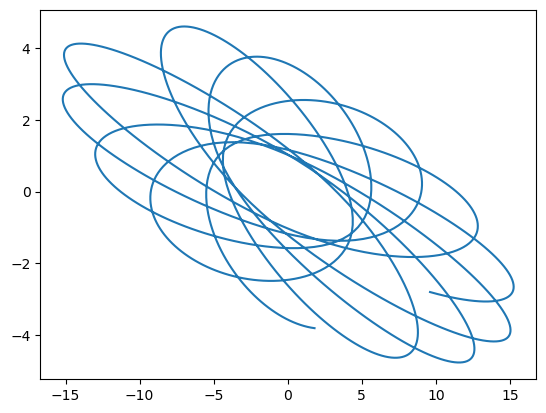

In [76]:
x = o2.x(ts)
y = o2.y(ts)
fig, ax = plt.subplots()
plt.plot(x, y)
plt.show()

In [65]:

# coords, velocities: shape (3, N)
x, y, z = np.transpose(coords_centred)
vx, vy, vz = np.transpose(velocities)

eps = 1*10**-12
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / (r + eps))
phi   = np.arctan2(y, x)

# precompute trig
st = np.sin(theta)
ct = np.cos(theta)
sp = np.sin(phi)
cp = np.cos(phi)

# r-hat
rx = st * cp
ry = st * sp
rz = ct

# theta-hat
tx = ct * cp
ty = ct * sp
tz = -st

# phi-hat
px = -sp
py =  cp
pz =  0.0

# --- velocity components ---
v_r     = vx * rx + vy * ry + vz * rz
v_theta = vx * tx + vy * ty + vz * tz
v_phi   = vx * px + vy * py + vz * pz

#Number of radial bins
nbins = 40

pos = [r, theta, phi]
vel = [v_r, v_theta, v_phi]
sigmas = []
centers = []
# --- Equal-number binning ---
# Sort by radius
for i in range(3):
    idx = np.argsort(pos[0])
    r_sorted = pos[0][idx]
    
    
    v_r_sorted = vel[i][idx]
    
    # Split into equal chunks
    r_chunks = np.array_split(r_sorted, nbins)
    v_chunks = np.array_split(v_r_sorted, nbins)
    
    # Compute bin centers and dispersions
    r_centers = np.array([chunk.mean() for chunk in r_chunks])
    centers.append(r_centers)
    
    sigma_r = np.array([
        np.sqrt(chunk_vr.mean()**2 * 0 +   # trick to keep dtype
                (np.mean(chunk_vr**2) - np.mean(chunk_vr)**2))
        for chunk_vr in v_chunks
    ])

    sigmas.append(sigma_r)


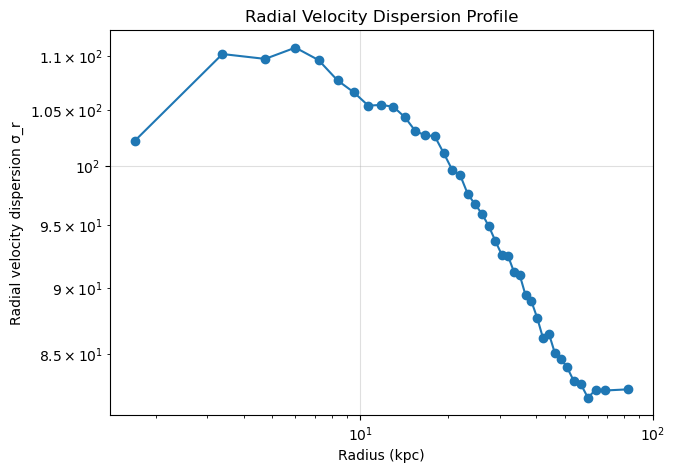

In [66]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(centers[0], sigmas[0], marker='o', lw=1.5)
plt.xlabel("Radius (kpc)")
plt.ylabel("Radial velocity dispersion σ_r")
plt.title("Radial Velocity Dispersion Profile")
plt.grid(True, alpha=0.4)
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)
plt.savefig('v_disp')
plt.show()


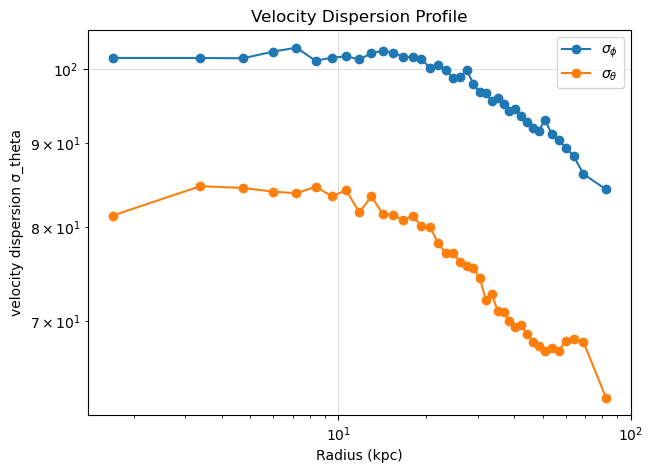

In [67]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(centers[2], sigmas[2], marker='o', lw=1.5, label=r'$\sigma_\phi$')
plt.plot(centers[1], sigmas[1], marker='o', lw=1.5, label=r'$\sigma_\theta$')
plt.xlabel("Radius (kpc)")
plt.ylabel("velocity dispersion σ_theta")
plt.title("Velocity Dispersion Profile")
plt.grid(True, alpha=0.4)
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)
plt.legend()
plt.savefig('v_disp')
plt.show()


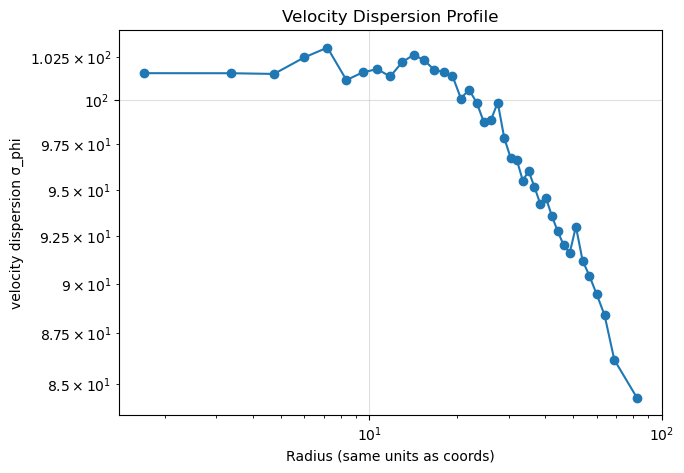

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(centers[2], sigmas[2], marker='o', lw=1.5)
plt.xlabel("Radius (kpc)")
plt.ylabel("velocity dispersion σ_phi")
plt.title("Velocity Dispersion Profile")
plt.grid(True, alpha=0.4)
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)
plt.savefig('v_disp')
plt.show()

In [19]:
anis_1 = 1 - (sigmas[1]**2/sigmas[0]**2) 
anis_2 = 1 - (sigmas[2]**2/sigmas[0]**2) 

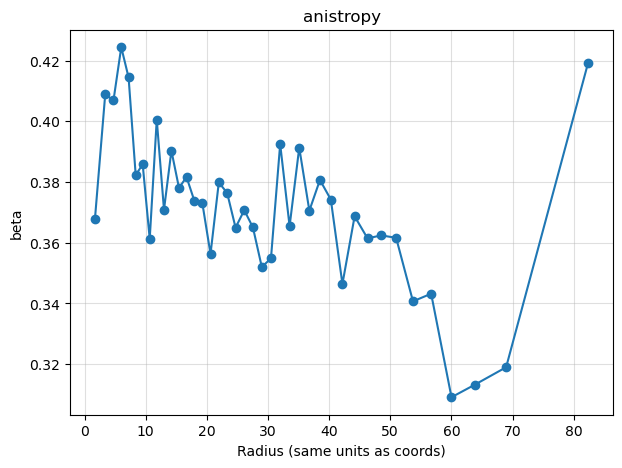

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(centers[2], anis_1, marker='o', lw=1.5)
plt.xlabel("Radius (kpc)")
plt.ylabel("beta")
plt.title("anistropy")
plt.grid(True, alpha=0.4)
plt.savefig('v_disp')
plt.show()

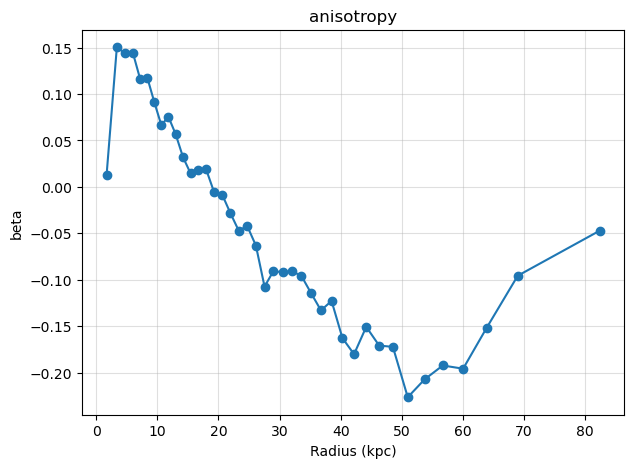

In [68]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(centers[2], anis_2, marker='o', lw=1.5)
plt.xlabel("Radius (kpc)")
plt.ylabel("beta")
plt.title("anisotropy")
plt.grid(True, alpha=0.4)
plt.savefig('v_disp')
plt.show()

In [71]:
from galpy.df import osipkovmerrittdf, eddingtondf
andf = osipkovmerrittdf(pot=Phi, rmax=300)
isdf = eddingtondf(pot=Phi, rmax=300)

In [72]:
rs = np.linspace(1, 300, 100)
sigma_ris = []
sigma_ran = []
for r in rs:
    sigma_ris.append(isdf.sigmar(r))* u.s/u.km
    sigma_ran.append(andf.sigmar(r))* u.s/u.km


C:\Users\brent\anaconda3\envs\TANA2025\Lib\site-packages\galpy\df\sphericaldf.py:275: RuntimeWarning: invalid value encountered in scalar divide
  return numpy.sqrt(self._vmomentdensity(r, 2, 0) / self._vmomentdensity(r, 0, 0))



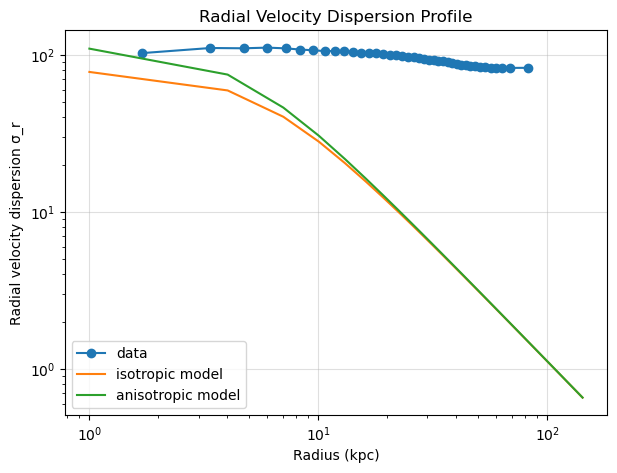

In [75]:
fig, ax = plt.subplots(figsize=(7,5))
sigma_ris_dimless = []
for sigma in sigma_ris:
    sigma_ris_dimless.append(220 * sigma * u.s/u.km)
sigma_ran_dimless = []
for sigma in sigma_ran:
    sigma_ran_dimless.append(220 * sigma * u.s/u.km)

plt.plot(centers[0], sigmas[0], marker='o', lw=1.5, label='data')
plt.plot(rs, sigma_ris_dimless, label='isotropic model')
plt.plot(rs, sigma_ran_dimless, label='anisotropic model')
plt.xlabel("Radius (kpc)")
plt.ylabel("Radial velocity dispersion σ_r")
plt.title("Radial Velocity Dispersion Profile")
plt.grid(True, alpha=0.4)
ax.set_yscale('log', base=10)
ax.set_xscale('log', base=10)
plt.legend()


plt.savefig('v_disp_dfs')
plt.show()